## ARIMA predicting stock prices

ARIMA predict stock prices --> convert to volatility

In [1]:
import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
import warnings
import yfinance as yf
import keras

In [2]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

Before 2021 train

After 2021 predict

Loading data

In [3]:
# Data for sampling for stocks
df = pd.read_csv("nasdaq_screener_1637265857363.csv")
df = df[df['Market Cap'].notna()]

# Data for prices

Sampling stocks from each of 6 company cap sizes

In [71]:
# defining units
M = 10**6
B = 10**9

# defining 6 categories for company cap
bins =  np.array([0,50*M,300*M,2*B,10*B,200*B,np.inf])
ind = np.digitize(df['Market Cap'], bins)

df['Cap Group'] = ind

gb = df.groupby('Cap Group')
list_of_groupbed_stocks = [gb.get_group(x) for x in gb.groups]

cap_list = ['nano','micro','small','medium','large','mega']
stock_cap_dict = dict()
for i in range(len(cap_list)):
    stock_cap_dict[cap_list[i]] = list_of_groupbed_stocks[i]['Symbol']

In [72]:
# changeable
sample_size = 50

stocks_smp = {}
for i in range(1, 7):
    cap = cap_list[i-1]
    stocks_smp[cap] = df[df['Cap Group'] == i].sample(n = sample_size, random_state = 42)['Symbol']

In [73]:
start = pd.Timestamp('2005-01-01')
end = pd.Timestamp('2020-04-09')

sp_data = web.DataReader('SPY', 'yahoo', start, end)\
      [['High','Low','Open','Close','Volume','Adj Close']]

sp_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3844 entries, 2005-01-03 to 2020-04-09
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       3844 non-null   float64
 1   Low        3844 non-null   float64
 2   Open       3844 non-null   float64
 3   Close      3844 non-null   float64
 4   Volume     3844 non-null   float64
 5   Adj Close  3844 non-null   float64
dtypes: float64(6)
memory usage: 210.2 KB


In [74]:
# Calculate daily returns as percentage price changes
sp_data['Return'] = 100 * (sp_data['Close'].pct_change())
sp_data['Log_Return'] = np.log(sp_data['Close']).diff().mul(100) # rescale to faciliate optimization
sp_data = sp_data.dropna()

In [75]:
# S&P 500
# Calculate daily std of returns
std_daily = sp_data['Return'].std()
print(f'Daily volatility: {round(std_daily,2)}%')

# Convert daily volatility to monthly volatility
std_monthly = np.sqrt(21) * std_daily
print(f'\nMonthly volatility: {round(std_monthly,2)}%')

# Convert daily volatility to annaul volatility
std_annual = np.sqrt(252) * std_daily
print(f'\nAnnual volatility: {round(std_annual,2)}%')

Daily volatility: 1.24%

Monthly volatility: 5.67%

Annual volatility: 19.63%


In [76]:
sp_data['Return'].std()

1.2368775334362172

Building ARIMA

In [25]:
# for cap in range(len(stocks_smp)):
#     for stock in cap:
#         # loading stock price data
#         df_stock = yf.download(stock, start="2010-01-01", end="2021-04-30")
#         # calculate daily logarithmic return
#         df_stock['Return'] = (np.log(df_stock.Close /
#             df_stock.Close.shift(-1)))
#         df_stock = df_stock[:-1]
#         # calculate daily standard deviation of returns
#         daily_std = np.std(df_stock.Return)
#         # annualized daily standard deviation
#         std = daily_std * 252 ** 0.5
        
#         # split training and test set

TypeError: 'int' object is not iterable

toy example

In [4]:
# APPL
start_time, end_time = "2010-01-01", "2021-04-30"
aapl = yf.download("AAPL", start= start_time, end=end_time)

# calculate daily logarithmic return
aapl['Return'] = (np.log(aapl.Close/ aapl.Close.shift(-1)))
aapl = aapl[:-1]

# calculate daily standard deviation of returns
daily_std = np.std(aapl.Return)

# annualized daily standard deviation
std = daily_std * 252 ** 0.5

[*********************100%***********************]  1 of 1 completed


In [ ]:
aapl.Close.shift(-1)

In [5]:
aapl

,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.553023,493729600,-0.001727
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.564355,601904800,0.016034
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.459941,552160000,0.001850
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.447998,477131200,-0.006626
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.490865,447610800,0.008861
...,...,...,...,...,...,...,...
2021-04-22,133.039993,134.149994,131.410004,131.940002,131.327560,84566500,-0.017878
2021-04-23,132.160004,135.119995,132.160004,134.320007,133.696518,78657500,-0.002973
2021-04-26,134.830002,135.059998,133.559998,134.720001,134.094650,66905100,0.002453


In [6]:
# Set target series
series = aapl['Return']

# Create train data set
train_split_date = '2020-01-02'
train_split_index = np.where(aapl.index == train_split_date)[0][0]
x_train = aapl.loc[aapl.index <= train_split_date]['Close']

In [7]:
# Create test data set
test_split_date = '2020-12-31'
test_split_index = np.where(aapl.index == test_split_date)[0][0]
x_test = aapl.loc[aapl.index >= test_split_date]['Close']

In [8]:
# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = aapl.loc[(aapl.index < test_split_date) & (aapl.index > train_split_date)]['Close']

#printed index values are: 
#0-5521(train), 5522-6527(valid), 6528-6947(test)

Check for stationarity

In [9]:
def test_stationarity(timeseries, window = 12, cutoff = 0.01):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
        print(dfoutput)

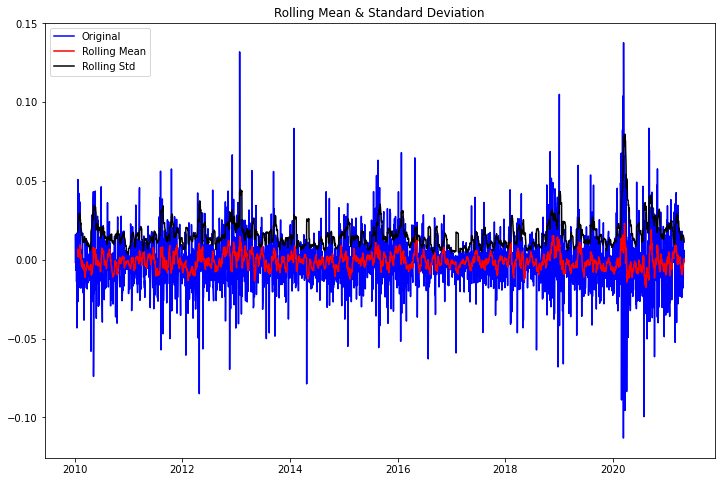

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.


In [10]:
test_stationarity(series)
# non-stationary

Fit ARIMA

In [11]:
# fit model
# fine tune: grid search
# z-score
# correlation evaluation

aapl_arima = ARIMA(x_train, order=(1,1,1))
aapl_arima_fit = aapl_arima.fit(disp=0)
print(aapl_arima_fit.summary())

/Users/yiwen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/yiwen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2516
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1742.313
Method:                       css-mle   S.D. of innovations              0.484
Date:                Fri, 19 Nov 2021   AIC                           3492.626
Time:                        22:22:41   BIC                           3515.948
Sample:                             1   HQIC                          3501.090
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0268      0.010      2.757      0.006       0.008       0.046
ar.L1.D.Close    -0.8375      0.139     -6.026      0.000      -1.110      -0.565
ma.L1.D.Close     0.8536      0.132     

/Users/yiwen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [12]:
# Create list of x train values
history = [x for x in x_train]
# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

# loop through every data point
for time_point in list(x_test.index):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0][0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)
MAE_error = keras.metrics.mean_absolute_error(x_test, model_predictions).numpy()
MAPE_error = mean_absolute_percentage_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))
print('Testing Mean Average Percentage Error is {}'.format(MAPE_error))
%store model_predictions

/Users/yiwen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/yiwen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsm

/Users/yiwen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/yiwen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsm

/Users/yiwen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/yiwen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsm

/Users/yiwen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/yiwen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsm

/Users/yiwen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/yiwen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsm

/Users/yiwen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/yiwen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsm

/Users/yiwen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/yiwen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsm

/Users/yiwen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/yiwen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsm

/Users/yiwen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Testing Mean Squared Error is 2.764942341533983
Testing Mean Average Percentage Error is 0.021333588867295174
Stored 'model_predictions' (list)


/Users/yiwen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [97]:
import matplotlib.pyplot as plt

In [30]:
model_predictions = np.diff(np.array(model_predictions)) / np.array(model_predictions)[1:]

In [31]:
x_test = np.diff(np.array(x_test)) / np.array(x_test)[1:]

In [129]:
x_test = (np.log(x_test/ x_test.shift(-1)))

/Users/yiwen/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


No handles with labels found to put in legend.


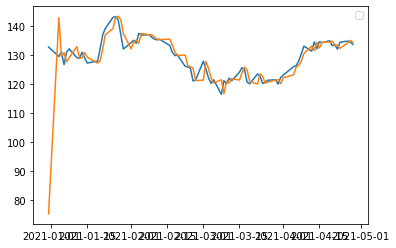

In [19]:
# stock price (close)
plt.plot(x_test)
plt.plot(x_test.index, model_predictions)
plt.legend()

No handles with labels found to put in legend.


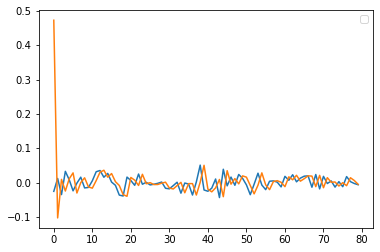

In [34]:
# daily log return
plt.plot(x_test)
plt.plot(model_predictions)
plt.legend()

In [35]:
MAE_error = keras.metrics.mean_absolute_error(x_test, model_predictions).numpy()
MAPE_error = mean_absolute_percentage_error(x_test, model_predictions)
print('Testing Mean Squared Error is {}'.format(MAE_error))
print('Testing Mean Average Percentage Error is {}'.format(MAPE_error))

Testing Mean Squared Error is 0.028644656343893748
Testing Mean Average Percentage Error is 3.159980291243258


Reload model

In [ ]:
# %store model_predictions
%store -r model_predictions
# Check to see if it reloaded
model_predictions[:5]
# Load model
from statsmodels.tsa.arima.model import ARIMAResults
loaded = ARIMAResults.load('arima_111.pkl')